In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn.decomposition import PCA

In [2]:
#load the datasets
train=pd.read_csv("C:/Users/chandrashekar/Desktop/Machine Learning/Practice/House Prediction/train.csv")
test=pd.read_csv("C:/Users/chandrashekar/Desktop/Machine Learning/Practice/House Prediction/test.csv")

In [3]:
#explore dataset
train_shape=print("shape of training data set:" ,train.shape)
test_shape=print("shape of test data set:" ,test.shape)

shape of training data set: (1460, 81)
shape of test data set: (1459, 80)


In [4]:
#null values
missingvalues=train.columns[train.isnull().any()]
print("Training_missing_values:",train[missingvalues].isnull().sum().sort_values(ascending=False))

Training_missing_values: PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [5]:
percentage=(train[missingvalues].isnull().sum()/train[missingvalues].isnull().count()).sort_values(ascending=False)
missing=train[missingvalues].isnull().sum().sort_values(ascending=False)
missing=pd.concat([missing,percentage],axis=1,keys=['total','percentage'])
missing

,total,percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


In [6]:
#datatypes
train_datatypes=print("Structure of training data set:\n",
                      train.dtypes.value_counts())

Structure of training data set:
 object     43
int64      35
float64     3
dtype: int64


In [98]:
train["SalePrice"]

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1430    12.165985
1431    11.875838
1432    11.074436
1433    12.136192
1434    11.982935
1435    12.066816
1436    11.699413
1437    12.885673
1438    11.916395
1439    12.190964
1440    12.160034
1441    11.913720
1442    12.644331
1443    11.703554
1444    12.098493
1445    11.767575
1446    11.969724
1447    12.388398
1448    11.626263
1449    11.429555
1450    11.820418
1451    12.567555
1452    11.884496
1453    11.344519
1454    12

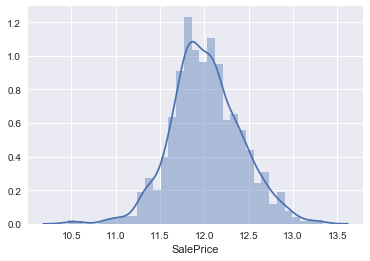

In [71]:
train["SalePrice"].describe()
sns.distplot(train["SalePrice"])
y = np.log1p(train["SalePrice"])

In [8]:
#skewness and kurtosis
print("Skewness:",train['SalePrice'].skew())
print("Kurtosis:",train['SalePrice'].kurt())

Skewness: 0.121346619897
Kurtosis: 0.809519155708


In [9]:
#corelation with dependent varibales
correlations=train.corr()
threshold = 0.5 
corr_lists=[]
for i in range(0,38):
    for j in range(i,38):
        if(correlations.iloc[i,j]>=0.6 and correlations.iloc[i,j]<1) or (correlations.iloc[i,j]<0 and correlations.iloc[i,j]<=-0.6):
            corr_lists.append([correlations.iloc[i,j],i,j])
sorted_corrr=sorted(corr_lists)
cols=correlations.columns
for k,a,b in sorted_corrr:
    print("%s and %s =%.2f" %(cols[a],cols[b],k))

OverallQual and GarageCars =0.60
2ndFlrSF and HalfBath =0.61
TotalBsmtSF and SalePrice =0.61
2ndFlrSF and TotRmsAbvGrd =0.62
GrLivArea and FullBath =0.63
YearRemodAdd and GarageYrBlt =0.64
BsmtFinSF1 and BsmtFullBath =0.65
GarageArea and SalePrice =0.65
BedroomAbvGr and TotRmsAbvGrd =0.68
GarageCars and SalePrice =0.68
2ndFlrSF and GrLivArea =0.69
GrLivArea and SalePrice =0.70
OverallQual and SalePrice =0.82
TotalBsmtSF and 1stFlrSF =0.82
GrLivArea and TotRmsAbvGrd =0.83
YearBuilt and GarageYrBlt =0.83
GarageCars and GarageArea =0.88


In [10]:
#datatypes
train.select_dtypes(include=[np.object]).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis = 1, inplace = True)
test.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis = 1, inplace = True)

In [12]:
#filled with median & verify the information
train["LotFrontage"].fillna(train["LotFrontage"].median(),inplace=True)
train["LotFrontage"].isnull().sum()
test["LotFrontage"].fillna(test["LotFrontage"].median(),inplace=True)
test["LotFrontage"].isnull().sum()

0

In [13]:
#next mssing value is Garage. If we look at the missing data, all garage reference 
#details share the same amount of missing values and its likely they are in the same rows Lets see correlation
#can use pca to remove these. Multi-collinearity issue may arise
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
train[garage_cols][train['GarageYrBlt'].isnull()==True]

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0,0
48,NaN,NaN,NaN,NaN,NaN,0,0
78,NaN,NaN,NaN,NaN,NaN,0,0
88,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
99,NaN,NaN,NaN,NaN,NaN,0,0
108,NaN,NaN,NaN,NaN,NaN,0,0
125,NaN,NaN,NaN,NaN,NaN,0,0
127,NaN,NaN,NaN,NaN,NaN,0,0
140,NaN,NaN,NaN,NaN,NaN,0,0


In [14]:
#Lets see if we can impute based on Garage year built these details
#looks like they are depenedent on Year built
train.corr()["GarageYrBlt"].sort_values(ascending=False)

GarageYrBlt      1.000000
YearBuilt        0.825667
YearRemodAdd     0.642277
GarageCars       0.588920
GarageArea       0.564567
OverallQual      0.547766
SalePrice        0.541073
FullBath         0.484557
TotalBsmtSF      0.322445
MasVnrArea       0.252691
1stFlrSF         0.233449
GrLivArea        0.231197
OpenPorchSF      0.228425
WoodDeckSF       0.224577
HalfBath         0.196785
BsmtUnfSF        0.190708
BsmtFinSF1       0.153484
TotRmsAbvGrd     0.148112
BsmtFullBath     0.124553
MSSubClass       0.085072
2ndFlrSF         0.070832
LotFrontage      0.066497
Fireplaces       0.046822
3SsnPorch        0.023544
MoSold           0.005337
Id               0.000072
YrSold          -0.001014
PoolArea        -0.014501
LotArea         -0.024947
MiscVal         -0.032417
LowQualFinSF    -0.036363
BedroomAbvGr    -0.064518
ScreenPorch     -0.075418
BsmtHalfBath    -0.077464
BsmtFinSF2      -0.088011
KitchenAbvGr    -0.124411
EnclosedPorch   -0.297003
OverallCond     -0.324297
Name: Garage

In [15]:
train['GarageYrBlt'].fillna(train['YearBuilt'],inplace=True)
test['GarageYrBlt'].fillna(test['YearBuilt'],inplace=True)

In [16]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
train[garage_cols].isnull().sum()

GarageType      81
GarageQual      81
GarageCond      81
GarageYrBlt      0
GarageFinish    81
GarageCars       0
GarageArea       0
dtype: int64

In [17]:
#filling missing values for Garage
for col in garage_cols:
    if train[col].dtype==np.object:
        train[col] = train[col].fillna('None')

In [18]:
for col in garage_cols:
    if test[col].dtype==np.object:
        test[col] = test[col].fillna('None')

In [19]:
train["GarageCond"].dtype

dtype('O')

In [20]:
#analyzing basement
bsmt=['BsmtFinType2','BsmtExposure']
train[bsmt][train['BsmtFinType2'].isnull()==True]

,BsmtFinType2,BsmtExposure
17,NaN,NaN
39,NaN,NaN
90,NaN,NaN
102,NaN,NaN
156,NaN,NaN
182,NaN,NaN
259,NaN,NaN
332,NaN,No
342,NaN,NaN
362,NaN,NaN


In [21]:
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']
train[basement_cols][train['BsmtQual'].isnull()==True]
for col in basement_cols:
        train[col] = train[col].fillna('None')
for col in basement_cols:
        test[col] = test[col].fillna('None')

In [22]:
#there is a correlation between the sale price & vaneer area
mas=['MasVnrArea','MasVnrType']
train['SalePrice'][train['MasVnrArea'].isnull()==True]

234     12.285350
529     12.209193
650     12.235394
936     12.127576
973     12.111767
977     12.205578
1243    13.049795
1278    12.375820
Name: SalePrice, dtype: float64

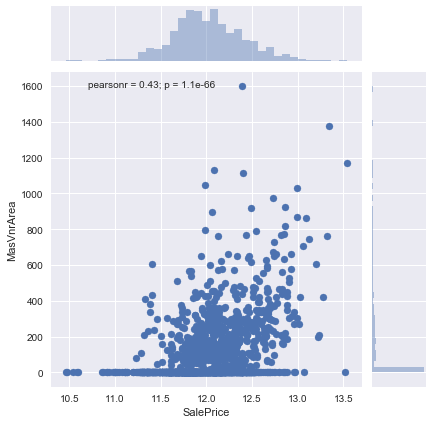

In [23]:
#looks like outliers :)
sns.jointplot(x="SalePrice", y="MasVnrArea", data=train)
#lets fill with na
train["MasVnrType"] = train["MasVnrType"].fillna('None')
train["MasVnrArea"] = train["MasVnrArea"].fillna(0.0)
test["MasVnrType"] = test["MasVnrType"].fillna('None')
test["MasVnrArea"] = test["MasVnrArea"].fillna(0.0)

In [24]:
test["Electrical"] = test["Electrical"].fillna('SBrkr')
train["Electrical"] = train["Electrical"].fillna('SBrkr')

In [25]:
train.isnull().sum().sum()

0

In [26]:
#null values
missingvalues=test.columns[test.isnull().any()]
print("Training_missing_values:",test[missingvalues].isnull().sum().sort_values(ascending=False))

Training_missing_values: MSZoning        4
Functional      2
BsmtHalfBath    2
BsmtFullBath    2
Utilities       2
SaleType        1
GarageArea      1
GarageCars      1
KitchenQual     1
TotalBsmtSF     1
BsmtUnfSF       1
Exterior2nd     1
Exterior1st     1
dtype: int64


In [27]:
test['BsmtHalfBath'].fillna(test["BsmtHalfBath"].mean(),inplace=True)
test['BsmtFullBath'].fillna(test["BsmtFullBath"].mean(),inplace=True)
test['TotalBsmtSF'].fillna(test["TotalBsmtSF"].mean(),inplace=True)
test['BsmtUnfSF'].fillna(test["BsmtUnfSF"].mean(),inplace=True)
test['GarageArea'].fillna(test["GarageArea"].mean(),inplace=True)
test['GarageCars'].fillna(test["GarageCars"].mean(),inplace=True)
test['MSZoning']= test['MSZoning'].fillna('RL').astype(str)
test['Functional']=test['Functional'].fillna('Typ')
test['SaleType']=test['SaleType'].fillna('WD')
test['KitchenQual']=test['KitchenQual'].fillna('TA')
test['Utilities']=test['Utilities'].fillna('AllPub')
test['Exterior2nd']=test['Exterior2nd'].fillna('VinylSd')
test['Exterior1st']=test['Exterior1st'].fillna('VinylSd')

In [28]:
#null values
missingvalues=test.columns[test.isnull().any()]
print("Training_missing_values:",test[missingvalues].isnull().sum().sort_values(ascending=False))

Training_missing_values: Series([], dtype: float64)


In [29]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [30]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)

In [31]:
all_df = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']), ignore_index=True)

In [32]:
#Feature engineering- New homes
all_df["NewerDwelling"] = all_df["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0}).astype(int)
all_df["Allagesstyles"] = all_df["MSSubClass"].replace(
        {20: 0, 30: 0, 40: 1, 45: 1,50: 1, 60: 0, 70: 0, 75: 1, 80: 0, 85: 0,
         90: 1, 120: 0, 150: 1, 160: 0, 180: 0, 190: 1}).astype(int)
all_df["Stories"]=all_df["MSSubClass"].map({20: 1, 30: 1, 40: 1, 45: 2,50: 2, 60: 3, 70: 3, 75: 4, 80: 5, 85: 5,
         90: 3, 120: 1, 150: 2, 160: 3, 180: 5, 190: 3}).astype(int)
all_df=all_df.drop("MSSubClass",axis=1)

In [33]:
#featureengineering- Lotshape-removing IR2*IR3 AS ONLY LESS 76+15 INSTANCES
all_df["LotShape"]=all_df["LotShape"].replace({"Reg":1,"IR1":0,"IR2":0,"IR3":0})

In [34]:
all_df["LotShape"].dtype

dtype('int64')

In [35]:
#LANDCOUNTOUR.Make everything Flat vs not flat
all_df["LandContour"]=all_df["LandContour"].replace({"Lvl":1,"HLS":0,"Bnk":0,"Low":0})

In [36]:
#make everything available vs not available
#all_df["Utilities"]=all_df["Utilities"].replace({"AllPub":1,"NoSewr":0,"NoSewa":0,"ELO":0})
#drop the column as it doesnt add any meaning
all_df=all_df.drop("Utilities",axis=1)

In [37]:
qual_dict = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
all_df["ExterQual"] = all_df["ExterQual"].map(qual_dict)
all_df["ExterCond"] = all_df["ExterCond"].map(qual_dict)
all_df["HeatingQC"] = all_df["HeatingQC"].map(qual_dict)
all_df["KitchenQual"] = all_df["KitchenQual"].map(qual_dict)


In [38]:


all_df["BsmtQual"] = all_df["BsmtQual"].replace({"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})
all_df["BsmtCond"] = all_df["BsmtCond"].replace({"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})

all_df["GarageQual"] = all_df["GarageQual"].replace({"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})

In [39]:
all_df["GarageCond"] = all_df["GarageCond"].replace({"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})

In [40]:
all_df["SaleType"]=all_df["SaleType"].replace({"WD":0,"CWD":0,"VWD":0,"New":1,"Con":2,"ConLw":2,"ConLI":2,"ConLD":2,"Oth":3,"COD":3})
all_df["SaleCondition"]=all_df["SaleCondition"].replace({"Normal":0,"Partial":1,"Abnorml":1,"Family":1,"Alloca":1,"AdjLand":0})

In [41]:
all_df["AgeSincesold"]=all_df["YrSold"]-all_df["YearRemodAdd"]
all_df.YrSold = 2010 - all_df.YrSold

In [42]:
#may be based on seasons
all_df["MoSold"]=all_df["MoSold"].replace({1:0,2:0,3:0,4:1,5:1,6:1,7:2,8:2,9:2,10:3,11:3,12:3})

In [43]:
#Misval is skewed-lets replace

In [44]:
#total porch area
all_df["Totalporcharea"]=all_df["WoodDeckSF"]+all_df["OpenPorchSF"]+all_df["EnclosedPorch"]+all_df["3SsnPorch"]+all_df["ScreenPorch"]
all_df["Totalporcharea"]=np.log1p(all_df["Totalporcharea"])

#lets say paved or not paved
all_df["PavedDrive"]=all_df["PavedDrive"].replace({"Y":0,"N":1,"P":1})

#functional
all_df["Functional"]=all_df["Functional"].replace({"Typ":0,"Min1":1,"Min2":1,"Mod":1,"Maj1":1,"Maj2":1,"Sev":1,"Sal":1})

In [45]:
all_df["MSZoning"]=all_df["MSZoning"].replace({"RL":0,"RH":0,"RP":0,"RM":0,"C (all)":1,"FV":1})
all_df["LandSlope"]=all_df["LandSlope"].replace({"Gtl":0,"Mod":1,"Sev":1})
all_df["Condition2"]=all_df["Condition2"].replace({"Norm":1,"Feedr":0,"Artery":0,"RRAn":0,"PosN":0,"RRAe":0,"PosA":0,"RRNn":0,"RRNe":0})
all_df["CentralAir"]=all_df["CentralAir"].replace({"Y":0,"N":1})
all_df["Electrical"]=all_df["Electrical"].replace({"SBrkr":1,"FuseA":0,"FuseF":0,"FuseP":0,"Mix":0})
all_df["Condition1"]=all_df["Condition1"].replace({"Norm":1,"Feedr":0,"Artery":0,"RRAn":0,"PosN":0,"RRAe":0,"PosA":0,"RRNn":0,"RRNe":0})

In [46]:
bins = [-3,2,10,20,100]
group_names = ['Brand', 'new', 'medium', 'old']
all_df["Buildingstatus"]=pd.cut(all_df["AgeSincesold"],bins, labels=group_names)
all_df=all_df.drop("AgeSincesold",axis=1)

In [47]:
all_df["Age"]=2018-all_df["YearBuilt"]
bins = [0,10,50,100,200]
group_names = ['Brand', 'new', 'medium', 'old']
all_df["Age"]=pd.cut(all_df["Age"],bins, labels=group_names)

In [48]:
all_df["GarageAge"]=2018-all_df["GarageYrBlt"]
bins = [-1000,20,30,50,1000]
group_names = ['Brand', 'new', 'medium', 'old']
all_df["GarageAge"]=pd.cut(all_df["GarageAge"],bins, labels=group_names)

In [49]:
all_df['GarageAge'].value_counts()

old       1059
Brand      930
medium     608
new        318
Name: GarageAge, dtype: int64

In [50]:
all_df.shape

(2915, 79)

In [53]:
all_df= pd.get_dummies(all_df)

In [54]:
all_df.shape

(2915, 1466)

In [55]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [56]:
traind=all_df.loc[:1455,:]
testd=all_df.loc[1456:,:]

In [57]:
X_scaled = scaler.fit(traind).transform(traind)

In [58]:
test_X_scaled = scaler.transform(testd)

In [63]:
from sklearn.preprocessing import StandardScaler
Train_std = StandardScaler().fit_transform(traind)
test_std=StandardScaler().fit_transform(testd)

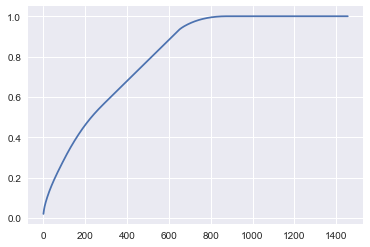

In [64]:
pca = PCA().fit(Train_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [65]:
sklearn_pca = PCA(n_components=800)
pca_train = sklearn_pca.fit_transform(Train_std)
pca_test = sklearn_pca.transform(test_std)

In [70]:
pca_train.shape ,pca_test.shape

((1456, 800), (1459, 800))

In [89]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

folds = 10
kf = KFold(n_splits=folds, random_state=1001)
for i, (train_index, val_index) in enumerate(kf.split(pca_train, y)):
    Xtrain, Xval = pca_train[train_index], pca_train[val_index]
    ytrain, yval = y[train_index], y[val_index]
    model = Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
    model.fit(pca_train, y)
    predsR = model.predict(pca_test)

In [108]:
from sklearn.linear_model import ElasticNet
folds = 10
kf = KFold(n_splits=folds, random_state=1001)
for i, (train_index, val_index) in enumerate(kf.split(pca_train, y)):
    Xtrain, Xval = pca_train[train_index], pca_train[val_index]
    ytrain, yval = y[train_index], y[val_index]
    model = ElasticNet(alpha=0.0004, l1_ratio=1.2)
    model.fit(pca_train, y)
    predse = model.predict(pca_test)

In [76]:
def rmsle(y, y0):
     assert len(y) == len(y0)
     return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))


In [81]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
foldss = 10
kfs = KFold(n_splits=foldss, random_state=1001)
for i, (train_index, val_index) in enumerate(kfs.split(pca_train, y)):
    Xtrain, Xval = pca_train[train_index], pca_train[val_index]
    ytrain, yval = y[train_index], y[val_index]
    train_X, valid_X, train_y, valid_y = train_test_split(pca_train, y, test_size = 0.15, random_state = 144)
    regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)
    regr.fit(pca_train, y)
    y_pred_xgb = regr.predict(pca_test)

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
parameters = {'alpha':(0.1,1,10), 'normalize':["True", "False"]}
clf=Lasso()
a=GridSearchCV(clf,parameters,scoring='neg_mean_squared_error')
a.fit(pca_train, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': (0.1, 1, 10), 'normalize': ['True', 'False']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [112]:
import math
y_pred = 0.1*y_pred_xgb + 0.45*predsR+predse*0.45
y_pred = np.expm1(y_pred)

pred_df = pd.DataFrame(y_pred, index=test["Id"], columns=["SalePrice"])
pred_df.to_csv('output.csv', header=True, index_label='Id')

In [114]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

In [115]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [116]:
a = Imputer().fit_transform(pca_train)
b = Imputer().fit_transform(y.values.reshape(-1,1)).ravel()

In [146]:
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.3, kernel='polynomial', degree=2, coef0=1.85)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

In [147]:
stack_model = stacking(mod=[lasso,ridge,regr,bay],meta_model=ker)

In [148]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [149]:
score = rmse_cv(stack_model,a,b)
print(score.mean())

0.0102681440244


In [150]:
stack_model = stacking(mod=[lasso,ridge,regr,bay],meta_model=ker)

In [151]:
stack_model.fit(a,b)

stacking(meta_model=KernelRidge(alpha=0.3, coef0=1.85, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [152]:
pred = np.expm1(stack_model.predict(pca_test))

In [153]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)

In [127]:
from sklearn.ensemble import RandomForestRegressor

In [130]:
label_df = pd.DataFrame(index = y.index, columns=["SalePrice"])

In [131]:
label_df.shape

(1456, 1)

In [137]:
class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y)

    def predict(self, X):
        self.predictions_ = list()
        for regressor in self.regressors:
            self.predictions_.append(np.exp(regressor.predict(X).ravel()))

        return np.log1p(np.mean(self.predictions_, axis=0))

In [138]:
regr1 = xgb.XGBRegressor(colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=30000,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

best_alpha = 0.00098
regr2 = Lasso(alpha=best_alpha, max_iter=50000)

regr3 = ElasticNet(alpha=0.001)

regr4 = KernelRidge(alpha=0.3, kernel='polynomial', degree=2, coef0=1.85)

regr = CustomEnsembleRegressor([regr1, regr2, regr3, regr4])

In [139]:
regr.fit(pca_train, y)

# Run prediction on the Kaggle test set.
y_preds = regr.predict(pca_test)

In [140]:
score = rmse_cv(regr,pca_train,y)
print(score.mean())

0.0741702585904


In [141]:
y_preds=np.expm1(y_preds)

In [142]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':y_preds})
result.to_csv("submission.csv",index=False)